In [1]:
import numpy as np
import nibabel as nib
import glob
import pandas as pd
import random
import os
#from tensorflow.keras.utils import to_categorical

from matplotlib import pyplot as plt
from tifffile import imsave
from sklearn.preprocessing import MinMaxScaler

# Loading in the data

There are a few datasets:
* Dataset of images
* Dataset of mappings between images in this dataset and previous versions of the dataset
* Dataset of survival information of patient

In [2]:
TRAIN_DATASET_PATH = 'data/training/'

NAME_MAPPING_CSV = TRAIN_DATASET_PATH + 'name_mapping.csv'
train_df_nm = pd.read_csv(NAME_MAPPING_CSV)
train_df_nm.head(5)

,Grade,BraTS_2017_subject_ID,BraTS_2018_subject_ID,TCGA_TCIA_subject_ID,BraTS_2019_subject_ID,BraTS_2020_subject_ID
0,HGG,Brats17_CBICA_AAB_1,Brats18_CBICA_AAB_1,NaN,BraTS19_CBICA_AAB_1,BraTS20_Training_001
1,HGG,Brats17_CBICA_AAG_1,Brats18_CBICA_AAG_1,NaN,BraTS19_CBICA_AAG_1,BraTS20_Training_002
2,HGG,Brats17_CBICA_AAL_1,Brats18_CBICA_AAL_1,NaN,BraTS19_CBICA_AAL_1,BraTS20_Training_003
3,HGG,Brats17_CBICA_AAP_1,Brats18_CBICA_AAP_1,NaN,BraTS19_CBICA_AAP_1,BraTS20_Training_004
4,HGG,Brats17_CBICA_ABB_1,Brats18_CBICA_ABB_1,NaN,BraTS19_CBICA_ABB_1,BraTS20_Training_005


In [3]:
NAME_MAPPING_CSV = TRAIN_DATASET_PATH+'survival_info.csv'
train_df_si=pd.read_csv(NAME_MAPPING_CSV)
train_df_si.head(5)

,Brats20ID,Age,Survival_days,Extent_of_Resection
0,BraTS20_Training_001,60.463,289,GTR
1,BraTS20_Training_002,52.263,616,GTR
2,BraTS20_Training_003,54.301,464,GTR
3,BraTS20_Training_004,39.068,788,GTR
4,BraTS20_Training_005,68.493,465,GTR


## Looking at some images

Image number 100
Image Shapes
Flair   (240, 240, 155)
T1      (240, 240, 155)
T1ce    (240, 240, 155)
T2      (240, 240, 155)
Mask    (240, 240, 155)


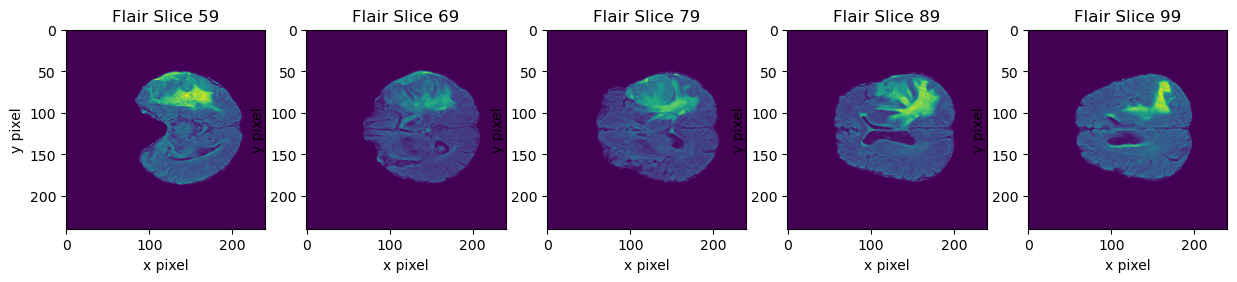

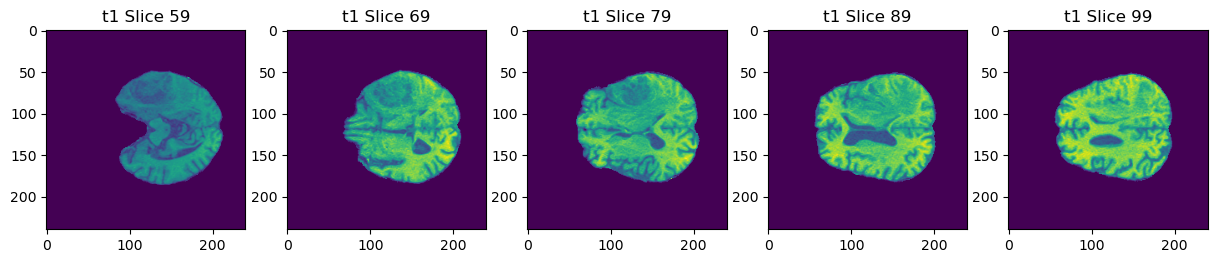

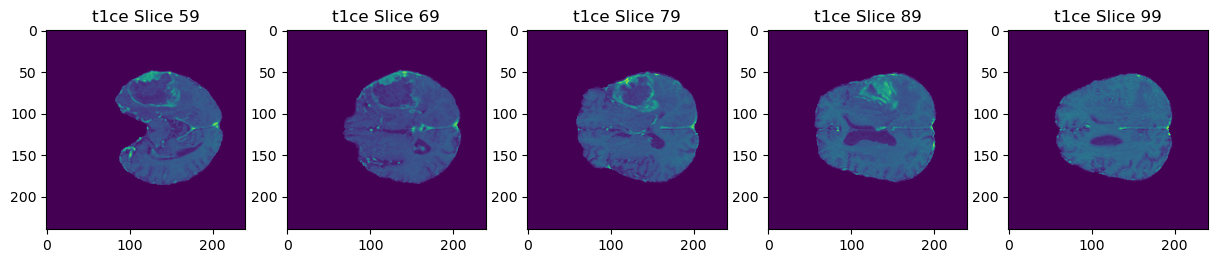

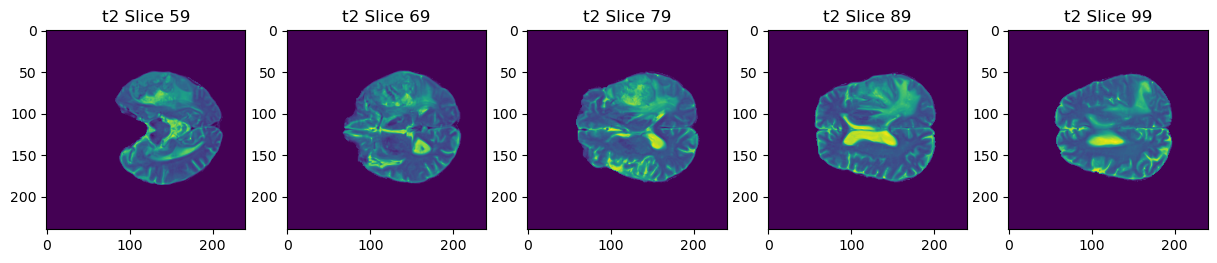

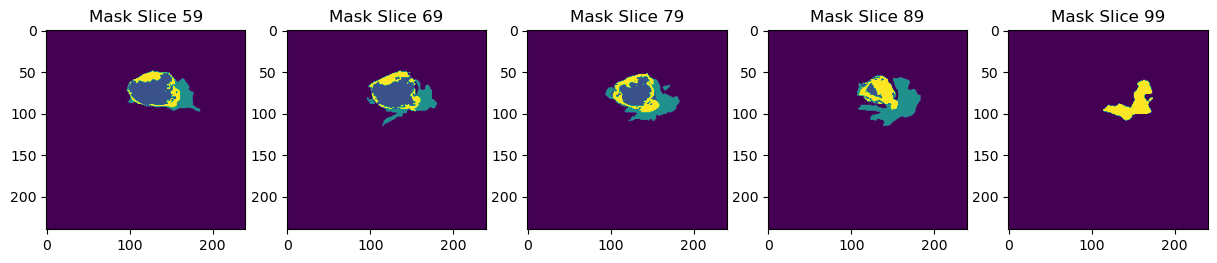

In [4]:
def visualize_subject(subject):

    print("Image number", subject)
    base_path = TRAIN_DATASET_PATH + 'BraTS20_Training_' + str(subject).zfill(3) + '/BraTS20_Training_' + str(subject).zfill(3)

    image_flair = nib.load(base_path + '_flair.nii').get_fdata()
    image_t1 = nib.load(base_path + '_t1.nii').get_fdata()
    image_t1ce = nib.load(base_path + '_t1ce.nii').get_fdata()
    image_t2 = nib.load(base_path + '_t2.nii').get_fdata()
    image_mask = nib.load(base_path + '_seg.nii').get_fdata()

    print("Image Shapes")
    print("Flair  ", image_flair.shape)
    print("T1     ", image_t1.shape)
    print("T1ce   ", image_t1ce.shape)
    print("T2     ", image_t2.shape)
    print("Mask   ", image_mask.shape)

    # test_image_flair[:,:,n_slice]
    for i in range(5):
        slice = 59 + i * 10

        plt.subplot(5, 5,i + 1)
        plt.title("Flair Slice " + str(slice))
        plt.xlabel("x pixel")
        plt.ylabel('y pixel')
        plt.imshow(image_flair[:,:,59 + i*10])
        plt.gcf().set_size_inches(15, 15)
    plt.show()

    for i in range(5):
        slice = 59 + i * 10
        plt.subplot(5, 5,i + 1)
        plt.title("t1 Slice " + str(slice))
        plt.imshow(image_t1[:,:,59 + i*10])
        plt.gcf().set_size_inches(15, 15)
    plt.show()

    for i in range(5):
        slice = 59 + i * 10
        plt.subplot(5, 5,i + 1)
        plt.title("t1ce Slice " + str(slice))
        plt.imshow(image_t1ce[:,:,59 + i*10])
        plt.gcf().set_size_inches(15, 15)
    plt.show()

    for i in range(5):
        slice = 59 + i * 10
        plt.subplot(5, 5,i + 1)
        plt.title("t2 Slice " + str(slice))
        plt.imshow(image_t2[:,:,59 + i*10])
        plt.gcf().set_size_inches(15, 15)
    plt.show()

    for i in range(5):
        slice = 59 + i * 10
        plt.subplot(5, 5,i + 1)
        plt.title("Mask Slice " + str(slice))
        plt.imshow(image_mask[:,:,59 + i*10])
        plt.gcf().set_size_inches(15, 15)
    plt.show()


visualize_subject(random.randint(0, 371))

## Validate File Presence
### Load all mri brain scans

In [5]:
t1_list = sorted(glob.glob(TRAIN_DATASET_PATH + '/*/*t1.nii'))
t2_list = sorted(glob.glob(TRAIN_DATASET_PATH + '/*/*t2.nii'))
t1ce_list = sorted(glob.glob(TRAIN_DATASET_PATH + '/*/*t1ce.nii'))
flair_list = sorted(glob.glob(TRAIN_DATASET_PATH + '/*/*flair.nii'))
mask_list = sorted(glob.glob(TRAIN_DATASET_PATH + '/*/*seg.nii'))
file_list = sorted(glob.glob(TRAIN_DATASET_PATH + '/*'))
brainFile_list = list(filter(lambda x: x[-3:]!='csv',file_list))

# are they the same?
print(len(brainFile_list))
print(len(t1_list))
print(len(t2_list))
print(len(t1ce_list))
print(len(flair_list))
print(len(mask_list))


369
369
369
369
369
368


### Find Missing mask file

In [6]:
# Looking for missing files
for brainFile in brainFile_list:
    if not os.path.isdir(brainFile):
        print("Skipping", brainFile)
        continue

    fileNum = brainFile[-3:]

    t1 = brainFile + '/BraTS20_Training_' + fileNum + '_t1.nii'
    t1ce = brainFile + '/BraTS20_Training_'+ fileNum + '_t1ce.nii'
    t2 = brainFile + '/BraTS20_Training_' + fileNum + '_t2.nii'
    flair = brainFile + '/BraTS20_Training_' + fileNum + '_flair.nii'
    mask = brainFile + '/BraTS20_Training_' + fileNum + '_seg.nii'

    if t1 not in t1_list:
        print(fileNum)
        print('t1 missing in '+fileNum)
        
    if t1ce not in t1ce_list:
        print('t1ce missing in '+fileNum)
    
    if t2 not in t2_list:
        print('t2 missing in '+fileNum)
    
    if flair not in flair_list:
        print('flair missing in '+fileNum)
    
    if mask not in mask_list:
        print('mask missing in '+fileNum)
        

mask missing in 355


## Analyze Mask labels

In [11]:
#No Label 3
mask_list_img_sample_list=np.array(list((map(lambda n: np.array(nib.load(n).dataobj), random.sample(mask_list, 5)))))
mask_np=mask_list_img_sample_list.reshape(-1)

print(np.unique(mask_np))
mask_np[mask_np==4] = 3 
print(np.unique(mask_np)) 

[0 1 2 4]
[0 1 2 3]


## Analyze Pixel distribution

In [13]:
#ANALYZING PIXEL VALUES
import random

#converting sample of t1 images into list of numpy array
t1_img_sample_list=np.array(list((map(lambda n: np.array(nib.load(n).dataobj), random.sample(t1_list, 5)))))
t1ce_img_sample_list=np.array(list((map(lambda n: np.array(nib.load(n).dataobj), random.sample(t1ce_list, 5)))))
t2_img_sample_list=np.array(list((map(lambda n: np.array(nib.load(n).dataobj), random.sample(t2_list, 5)))))
flair_img_sample_list=np.array(list((map(lambda n: np.array(nib.load(n).dataobj), random.sample(flair_list, 5)))))

t1_np=t1_img_sample_list.reshape(-1)
t1ce_np=t1ce_img_sample_list.reshape(-1)
t2_np=t2_img_sample_list.reshape(-1)
flair_np=flair_img_sample_list.reshape(-1)


In [ ]:
plt.rcParams["figure.autolayout"] = True
data = pd.DataFrame({"t1": t1_np, "t1ce": t1ce_np, "t2":t2_np, "flair":flair_np})
ax = data[['t1', 't1ce','t2','flair']].plot(kind='box', title='Distribution of MRI scan Pixel Values')

#plt.boxplot(nparray)
plt.show()

## Comparing T1 and T1ce

In [7]:
def process(file, file_mask):
    image = nib.load(file).get_fdata()
    mask = nib.load(file_mask).get_fdata()

    image=image[56:184, 56:184, 13:141]
    mask=mask[56:184, 56:184, 13:141]

    f_image = image.reshape(-1)
    f_mask = mask.reshape(-1)

    no_label = f_image[f_mask == 0]
    label = f_image[f_mask > 0]
    
    return label.sum(), no_label.sum()

t1_sum_label, t1_sum_no_label = 0,0
t1ce_sum_label, t1ce_sum_no_label = 0,0
t2_sum_label, t2_sum_no_label = 0,0
flair_sum_label, flair_sum_no_label = 0,0

base = TRAIN_DATASET_PATH + "/BraTS20_Training_"
n = 128*128*128*369*0.1
count = -1
for _ in range(int(369 * 0.1)):
    sample = random.randint(0, 369)

    fileNum = str(sample).zfill(3)

    t1 = base + fileNum + '/BraTS20_Training_' + fileNum + '_t1.nii'
    t1ce = base + fileNum + '/BraTS20_Training_'+ fileNum + '_t1ce.nii'
    t2 = base + fileNum + '/BraTS20_Training_' + fileNum + '_t2.nii'
    flair = base + fileNum + '/BraTS20_Training_' + fileNum + '_flair.nii'
    mask = base + fileNum + '/BraTS20_Training_' + fileNum + '_seg.nii'

    tmp = process(t1, mask)
    t1_sum_label += tmp[0]
    t1_sum_no_label += tmp[1]

    tmp = process(t1ce, mask)
    t1ce_sum_label += tmp[0]
    t1ce_sum_no_label += tmp[1]

    tmp = process(t2, mask)
    t2_sum_label += tmp[0]
    t2_sum_no_label += tmp[1]

    tmp = process(flair, mask)
    flair_sum_label += tmp[0]
    flair_sum_no_label += tmp[1]

print("t1", t1_sum_label / n, t1_sum_no_label / n, (t1_sum_no_label - t1_sum_label) / n)
print("t1ce", t1ce_sum_label / n, t1ce_sum_no_label / n, (t1ce_sum_no_label - t1ce_sum_label) / n)
print("t2", t2_sum_label / n, t2_sum_no_label / n, (t2_sum_no_label - t2_sum_label) / n)
print("flair", flair_sum_label / n, flair_sum_no_label / n, (flair_sum_no_label - flair_sum_label) / n)


t1 28.920843449006675 309.68834369065405 280.7675002416473
t1ce 31.91653775005806 351.86020188215304 319.94366413209497
t2 45.734470077537694 310.27113066009537 264.53666058255766
flair 28.504063156043433 169.6389207673086 141.13485761126518


In [8]:
scaler = MinMaxScaler()
def process(file, file_mask):
    image = nib.load(file).get_fdata()
    mask = nib.load(file_mask).get_fdata()

    

    image = image[56:184, 56:184, 13:141]
    mask = mask[56:184, 56:184, 13:141]

    image = scaler.fit_transform(image.reshape(-1, image.shape[-1])).reshape(image.shape)
    
    f_image = image.reshape(-1)
    f_mask = mask.reshape(-1)

    no_label = f_image[f_mask == 0]
    label = f_image[f_mask > 0]
    
    return label, no_label

n = 128*128*128*369*0.1
t1_sum_label, t1_sum_no_label = np.array([]), np.array([])
t1ce_sum_label, t1ce_sum_no_label = np.zeros([]), np.zeros([])
t2_sum_label, t2_sum_no_label = np.zeros([]), np.zeros([])
flair_sum_label, flair_sum_no_label = np.array([]), np.array([])

base = TRAIN_DATASET_PATH + "/BraTS20_Training_"
count = -1
for _ in range(int(369 * 0.1)):
    sample = random.randint(0, 369)

    fileNum = str(sample).zfill(3)

    t1 = base + fileNum + '/BraTS20_Training_' + fileNum + '_t1.nii'
    t1ce = base + fileNum + '/BraTS20_Training_'+ fileNum + '_t1ce.nii'
    t2 = base + fileNum + '/BraTS20_Training_' + fileNum + '_t2.nii'
    flair = base + fileNum + '/BraTS20_Training_' + fileNum + '_flair.nii'
    mask = base + fileNum + '/BraTS20_Training_' + fileNum + '_seg.nii'

    tmp = process(t1, mask)
    t1_sum_label = np.append(t1_sum_label, tmp[0])
    t1_sum_no_label = np.append(t1_sum_no_label, tmp[1])

    tmp = process(t1ce, mask)
    t1ce_sum_label = np.append(t1ce_sum_label, tmp[0])
    t1ce_sum_no_label = np.append(t1ce_sum_no_label, tmp[1])

    tmp = process(t2, mask)
    t2_sum_label = np.append(t2_sum_label, tmp[0])
    t2_sum_no_label = np.append(t2_sum_no_label, tmp[1])

    tmp = process(flair, mask)
    flair_sum_label = np.append(flair_sum_label, tmp[0])
    flair_sum_no_label = np.append(flair_sum_no_label, tmp[1])

print(t1_sum_label.shape, t1_sum_no_label.shape)
#print("t1", t1_sum_label / n, t1_sum_no_label / n, (t1_sum_label - t1_sum_no_label) / n)
#print("t1ce", t1ce_sum_label / n, t1ce_sum_no_label / n, (t1ce_sum_label - t1ce_sum_no_label) / n)
#print("t2", t2_sum_label / n, t2_sum_no_label / n, (t2_sum_label - t2_sum_no_label) / n)
#print("flair", flair_sum_label / n, flair_sum_no_label / n, (flair_sum_label - flair_sum_no_label) / n)


(3284813,) (72212659,)


In [ ]:
plt.subplot(1, 2, 1)
plt.title("T1 Label")
plt.boxplot(t1_sum_label, notch=None, vert=None, patch_artist=None, widths=None)
plt.subplot(1, 2, 2)
plt.title("T2 No Label")
plt.boxplot(t1_sum_no_label, notch=None, vert=None, patch_artist=None, widths=None)
plt.show()

plt.subplot(1, 2, 1)
plt.title("T1CE Label")
plt.boxplot(t1ce_sum_label, notch=None, vert=None, patch_artist=None, widths=None)
plt.subplot(1, 2, 2)
plt.title("T1CE No Label")
plt.boxplot(t1ce_sum_no_label, notch=None, vert=None, patch_artist=None, widths=None)
plt.show()

plt.subplot(1, 2, 1)
plt.title("T2 Label")
plt.boxplot(t2_sum_label, notch=None, vert=None, patch_artist=None, widths=None)
plt.subplot(1, 2, 2)
plt.title("T2 No Label")
plt.boxplot(t2_sum_no_label, notch=None, vert=None, patch_artist=None, widths=None)
plt.show()

plt.subplot(1, 2, 1)
plt.title("Flair Label")
plt.boxplot(flair_sum_label, notch=None, vert=None, patch_artist=None, widths=None)
plt.subplot(1, 2, 2)
plt.title("Flair No Label")
plt.boxplot(flair_sum_no_label, notch=None, vert=None, patch_artist=None, widths=None)
plt.show()

In [ ]:
test_image_flair=scaler.fit_transform(test_image_flair.reshape(-1, test_image_flair.shape[-1])).reshape(test_image_flair.shape)
print(test_image_flair.max())
brainNumber='120'

test_image_t1=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_'+brainNumber+'/BraTS20_Training_'+brainNumber+'_t1.nii').get_fdata()
test_image_t1=scaler.fit_transform(test_image_t1.reshape(-1, test_image_t1.shape[-1])).reshape(test_image_t1.shape)

test_image_t1ce=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_'+brainNumber+'/BraTS20_Training_'+brainNumber+'_t1ce.nii').get_fdata()
test_image_t1ce=scaler.fit_transform(test_image_t1ce.reshape(-1, test_image_t1ce.shape[-1])).reshape(test_image_t1ce.shape)

test_image_t2=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_'+brainNumber+'/BraTS20_Training_'+brainNumber+'_t2.nii').get_fdata()
test_image_t2=scaler.fit_transform(test_image_t2.reshape(-1, test_image_t2.shape[-1])).reshape(test_image_t2.shape)

test_mask=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_'+brainNumber+'/BraTS20_Training_'+brainNumber+'_seg.nii').get_fdata()
test_mask=test_mask.astype(np.uint8)

In [ ]:
n_slice=random.randint(0, test_mask.shape[2])
m_slice=60
print(n_slice)
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.imshow(test_image_flair[:,:,n_slice], cmap='gray')
plt.title('Image flair')

plt.subplot(232)
plt.imshow(test_image_t1[:,:,n_slice], cmap='gray')
plt.title('Image t1')
plt.subplot(233)
plt.imshow(test_image_t1ce[:,:,n_slice], cmap='gray')
plt.title('Image t1ce')
plt.subplot(234)
plt.imshow(test_image_t2[:,:,n_slice], cmap='gray')
plt.title('Image t2')
plt.subplot(235)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')

plt.show()
